<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/sythetic_analysis_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 2.7MB/s 


In [2]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')
import renn

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/')
import synthetic.synthetic_data as syn
import synthetic.training as syn_train
import synthetic.analysis as syn_an

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(syn)
reload(syn_train)
reload(syn_an)

<module 'synthetic.analysis' from '/content/drive/My Drive/ml_research/fixedpoints_nlp/synthetic/analysis.py'>

In [4]:
# Skips any tests and just runs function definitions
run_tests = False

# Synthetic Data: Toy Data Tests

In [2]:
# Various tests/confirmations of phrase generation
run_tests = True
if run_tests:
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 5,
    'unordered_class': False, # Use an unordered class set (red, green, blue)
    'n_unordered': 3,
    'extreme_test': False,
    'corr_vals': {},
    'the_padding': False,
    'words': ['good', 'bad', 'the'], # ['kinda0', 'kinda1', 'kinda2', 'the'],
    'uniform_score': True,
    'outer_prod': False
    # 'eps2': 0.5,
    # 'eps5': 0.3,
    # 'filter': 3.0
  }

  # toy_params['words'] = generateWordBank(toy_params)
  # toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five', 'Six']
  # toy_params['sentiments'] = ['Red', 'Green', 'Blue']
  toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  toy_params['base_word_vals'] = syn.baseWordValues(toy_params)
  if toy_params['uniform_score'] and toy_params['unordered_class']:
    syn.check_word_bank_for_uniform_score(toy_params['words'], len(toy_params['sentiments']))
  elif toy_params['uniform_score'] and not toy_params['unordered_class']:
    syn.check_word_bank_for_uniform_score_ordered(toy_params['words'])

  # Makes five phrases and reports scores
  print('Five phrases and scores:')
  for i in range(5):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = syn.randomTrainingExample(toy_params)
    # toy_phrase = make_toy_phrase(toy_params)
    # print(toy_phrase)
    # score = eval_toy_phrase(toy_phrase, toy_params)
    # print('Score:', score, 'Phrase Length:', len(toy_phrase))

  # Test Tensor conversion of toy phrases
  sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = syn.randomTrainingExample(toy_params)
  print('Toy phrase:', phrase[:])
  print('Toy phrase score:', syn.eval_toy_phrase(phrase, toy_params))
  print('Tensor for phrase:', phrase_tensor[:10])
  print('Target mask:', target_mask)
  print('Shape of phrase tensor', phrase_tensor.shape)
  print('Sentiment tensor', sentiment_tensor[:10])
  print('Shape of sentiment tensor', sentiment_tensor.shape)

  # Random generation of training examples
  for i in range(4):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = syn.randomTrainingExample(toy_params)
    print('sentiment =', sentiment, '/ phrase =', phrase)

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  scores = []
  class_nums = np.zeros(len(toy_params['sentiments']))
  lengths = []
  for trial in range(trials):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = syn.randomTrainingExample(toy_params)
    class_nums += sentiment_tensor[toy_params['phrase_length']-1]

  print('Number of each class:', class_nums)

  # if not toy_params['unordered_class']:
  #   print('Variance:', np.var(scores))

  #   # Histogram of scores
  #   plt.hist(scores, bins=40)
  #   plt.show()

  # if toy_params['variable_length']:
  #   # Histogram of lengths
  #   plt.hist(lengths, bins=len(set(lengths)))
  #   plt.show()

Five phrases and scores:
Toy phrase: ['good', 'good', 'good', 'good', 'good', 'the', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'the', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'the', 'good', 'good', 'the', 'bad', 'good', 'bad']
Toy phrase score: 22.0
Tensor for phrase: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Target mask: [49]
Shape of phrase tensor (50, 3)
Sentiment tensor [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shape of sentiment tensor (50, 3)
sentiment = Neutral / phrase = ['good', 'the', 'bad', 'good', 'the', 'good', 'good', 'the', 'the', 'the', 'bad', 'the', 'the', 'bad', 'the', 'the', 'the', 'good', 'the', 'good', 'bad', 'bad', 'g

In [3]:
# Tests on score filters and uniform score distribution
if run_tests:
  toy_params = {
      'phrase_length': 48,
      'loss_type': 'XE',
      'words': ['kinda0', 'kinda1', 'kinda2'],
      'unordered_class': True, 
      'n_unordered': 3,
      'filter': 24,
      'uniform_score': True,
  }

  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  toy_params['base_word_vals'] = syn.baseWordValues(toy_params)

  toy_params['possible_scores'] = enumerate_scores(toy_params)
  print('Possible scores:', toy_params['possible_scores'])
  print('# Possible scores:', len(toy_params['possible_scores']))
  diff_dict = {}
  diff_count = {}
  for score in toy_params['possible_scores']:
    diff = score[0]-score[1]
    if diff in diff_dict:
      if diff_dict[diff] != np.argmax(score):
        print('Inconsistency for diff {}:'.format(diff), np.argmax(score), 'and',  diff_dict[diff])
    else:
      diff_dict[diff] = np.argmax(score)
      diff_count[diff] = 0
    
    # print('Diff is:', score[0]-score[1], 'Class is:', np.argmax(score))

  # Random generation of training examples
  for i in range(5):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = randomTrainingExample(toy_params)
    print('sentiment =', sentiment, '/ phrase =', phrase)

  trials = 10000
  correct = 0
  for i in range(trials):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = randomTrainingExample(toy_params)

    phrase_tensor_sum = np.sum(phrase_tensor, axis=0)
    diff = phrase_tensor_sum[0] - phrase_tensor_sum[1]
    diff_count[diff] += 1
    if np.abs(diff) < toy_params['phrase_length']/2:
      pred_tensor = np.asarray([0, 0, 1])
    elif diff >= toy_params['phrase_length']/2:
      pred_tensor = np.asarray([1, 0, 0])
    else:
      pred_tensor = np.asarray([0, 1, 0])
    if np.argmax(sentiment_tensor[toy_params['phrase_length']-1]) == np.argmax(pred_tensor):
      correct += 1
    else:
      print('Incorrect Score:', phrase_tensor_sum , 'diff:', diff, 'Guess:',  np.argmax(pred_tensor), 'Correct:', np.argmax(sentiment_tensor[toy_params['phrase_length']-1]))

  print('Accuracy:', correct/trials)
  plt.figure()
  plt.scatter(list(diff_count.keys()), list(diff_count.values()))

NameError: ignored

In [10]:
# Test on correlations data
if run_tests:
  toy_params = {
    'phrase_length': 12,
    'loss_type': 'XE',
    'context_words' : False,
    'unordered_class': True, # Use an unordered class set (red, green, blue)
    'n_unordered': 3,
    'corr_vals': {'01': 0.1, '02': 0.1}
  }

  toy_params['words'] = generateWordBank(toy_params)
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
  toy_params['base_word_vals'] = baseWordValues(toy_params)

  train_params, rnn_specs = {}, {}

  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    score = eval_toy_phrase(toy_phrase, toy_params)
    print(score)

  # trials = 10000
  # score_vals = np.zeros((toy_params['n_unordered'],))
  # for trial in range(trials):
  #   sentiment, _, sentiment_tensor, _, _ = randomTrainingExample(toy_params)
  #   score_vals += sentiment_tensor[toy_params['phrase_length']-1]

  # print('Scores:', score_vals)

In [11]:
# Test on extreme data
if run_tests:

  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': False, # Use an unordered class set (red, green, blue)
    'n_unordered': 7,
    'words': ['bad', 'good', 'the', 'extremely'],
    'sentiments': ['Bad', 'Neutral', 'Good'],
    'extreme_test': True
  }


  print('Five phrases and scores:')
  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    sentiment, sentiment_tensor = classifySentimentExtreme(toy_phrase, toy_params)
    print('Sentiment:', sentiment)

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  score_vals = np.zeros((3,))
  for trial in range(trials):
    sentiment, _, sentiment_tensor, _, _ = randomTrainingExample(toy_params)
    score_vals += sentiment_tensor[toy_params['phrase_length']-1]

  print('Scores:', score_vals)

In [12]:
if run_tests:
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': True, # Use an unordered class set
    'n_unordered': 2,
  }

  toy_params['words'] = ['kinda0', 'kinda2', 'the'] #generateWordBank(toy_params)
  # toy_params['words'].append('kinda01')
  # toy_params['words'].append('kinda01')
  # toy_params['words'].remove('kinda0')
  # toy_params['words'].remove('kinda1')
  # toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  scores = np.zeros((trials, toy_params['n_unordered']))
  for trial in range(trials):
    toy_phrase = make_toy_phrase(toy_params)
    score = eval_toy_phrase(toy_phrase, toy_params)
    scores[trial] = score

In [13]:
if run_tests:
  scores_adj =  np.zeros((trials, toy_params['n_unordered']))

  for i in range(toy_params['n_unordered']):
    print('Mean:'.format(i), np.mean(scores[:,i]))
    scores_adj[:,i] = scores[:,i] - np.mean(scores[:,i])

  print(np.cov(scores_adj.T))

# Train and Build Network

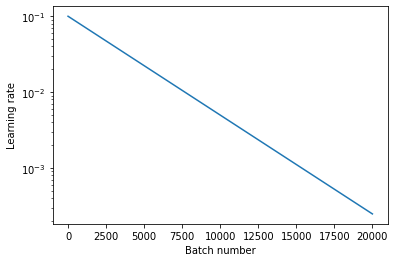

In [33]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [34]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'unordered_class': False, # Use an unordered class set
  'n_unordered': 2,
  'words': ['good', 'the', 'bad'], #['kinda0', 'bad0', 'kinda1', 'bad1', 'the'], #['kinda0', 'kinda1', 'the'],
  'uniform_score': True, # Uniform distribution over scores
  'outer_prod': False,
  'filter_classes': False
}

# toy_params['words'] = ['kinda0', 'kinda1', 'kinda2']
# toy_params['words'] = generateWordBank(toy_params)
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda12')
# toy_params['words'].append('kinda23')
# toy_params['words'].append('kinda03')
# toy_params['words'].remove('kinda0')
# toy_params['words'].extend(['kinda11110000','kinda00001111','kinda00110011','kinda11001100','kinda10101010','kinda01010101'])
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

toy_params['base_word_vals'] = syn.baseWordValues(toy_params)

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
  'loss_type': 'XE_binary' if toy_params['outer_prod']   else 'XE'
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 1e-3,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 10,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 300,
  'auto_balance': True,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = True

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_noRO_l2is1e-3_2.pickle'
save_data = syn_train.override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = syn_train.build_rnn(rnn_specs, train_params)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = syn_train.build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = syn_train.build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 20000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
opt_state, train_params = syn_train.train_on_synthetic_data(opt_state, step_fun, get_params, train_params, toy_params, rnn_specs, accuracy_fun)

train_params.pop('decay_fun') # Can't pickle with decay fun
syn_train.save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

Total words: 3 Words: ['good', 'the', 'bad']
Total sentiments: 5 Sentiments: ['One', 'Two', 'Three', 'Four', 'Five']
Looking for num per class: [25600. 25600. 25600. 25600. 25600.]
Sythentic data generated in: 11.36 sec. Autobalanced: True. Uniform score: True
Looking for num per class: [60. 60. 60. 60. 60.]
Sythentic data generated in: 0.04 sec. Autobalanced: True. Uniform score: True
Shuffling Data
Running batches 0 to 1000
Step 100 in 8.12 sec, step size: 0.09707, test acc 0.9133, avg training loss 0.9648
Step 200 in 1.78 sec, step size: 0.09420, test acc 0.8900, avg training loss 0.5362
Step 300 in 1.78 sec, step size: 0.09142, test acc 0.8800, avg training loss 0.4415
Step 400 in 1.79 sec, step size: 0.08872, test acc 0.9600, avg training loss 0.3592
Step 500 in 1.80 sec, step size: 0.08610, test acc 0.9500, avg training loss 0.3359
Step 600 in 1.83 sec, step size: 0.08355, test acc 0.9767, avg training loss 0.3084
Step 700 in 1.82 sec, step size: 0.08108, test acc 0.9867, avg tra

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5classrgb_minimal_eps5is05_noRO_l2is5e-4_2.pickle'

# train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

In [6]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2classrgb_2outer_filter00_noRO_l2is5e-4_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

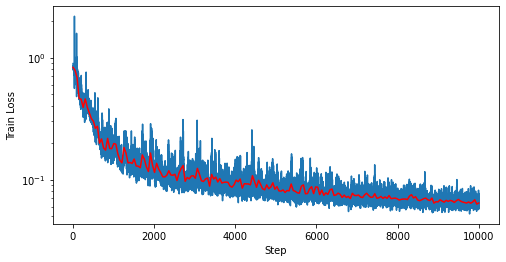

In [22]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [17]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 600

syn_data_test = syn.generate_data(n_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T
print('Readout shape:', readout.shape)

Using GRU cell
Filtering out classes: [0]
Looking for num per class: [  0. 200. 200. 200.]
Sythentic data generated in: 0.25 sec. Autobalanced: True. Uniform score: False
(14700, 128)
Readout shape: (2, 128)


Top 5 components: 0.99324685 ( [0.61030275 0.35690236 0.0151934  0.00854761 0.00230073] )
Participation Ratio: 1.9993374979939742
Copy this: PCA: [0.61030275 0.35690236 0.0151934  0.00854761 0.00230073] PR: 1.9993374979939742
Category 0 states: 400
Category 1 states: 200
Readout vec proj via PCA: [[ 2.7018461  -2.6948688 ]
 [ 1.6979883   1.9255362 ]
 [ 0.14334814  0.13047266]
 [-0.04368642  0.05783132]
 [-0.12093883  0.20841411]]


(128,)

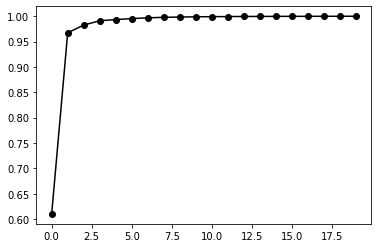

In [25]:
pc_dims = 5

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

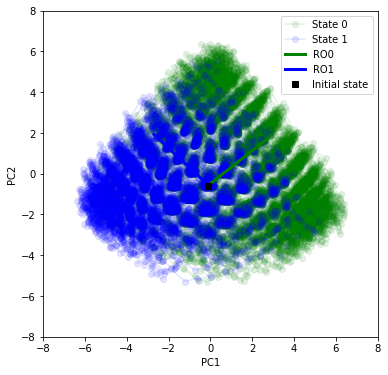

In [26]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(len(toy_params['sentiments'])):
  if len(states[i]) > 0:
    pca_states = pca.transform(np.vstack(states[i])).T
    plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.1, label=state_labels[i])

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# path_idxs = [52, 454, 252]
# for path_idx in path_idxs:
#   path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
#   plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(syn_data_test['labels'][path_idx][27])], marker='.', label='Random Path')
#   print('Path label:', syn_data_test['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coords = 8
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

plt.legend()

#### Readout Vector Analysis

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

# Percentage of readout vector mag in PCA dimensions
if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

print('Readout shape:', readout.shape)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

print('Theoretical angle:', 180/np.pi * np.arccos(-1/(toy_params['n_unordered']-1)))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)
# indices = [i for i in range(len(readout))]
# for i in range(len(readout)):
#   A = []
#   for j in range(len(readout)):
#     if i != j:
#       A.append(readout[j])
#   print('Perc of {} in rest:'.format(i), subspace_perc(np.asarray(A).T, readout[i]))

In [ ]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

ro_subspace_analysis(simplex)

### Find Fixed Points

In [29]:
word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
else:
  word_tensor = wordToTensor(word, toy_params['words'])[0]

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))


fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-4, steps=range(10000))
print('Done')

Using word tensor: [0.2 0.2 0.2 0.2 0.2]
Done


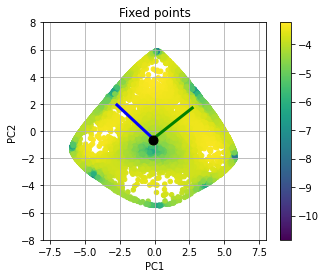

In [30]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '.', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

plot_coords = 8
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
# ro_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
# for i in range(len(readout)):
#   ro_dir = np.matmul(comp, readout[i])
#   x_ro = [pca_h0[pc1], ro_dir[pc1]]
#   y_ro = [pca_h0[pc2], ro_dir[pc2]]
#   z_ro = [pca_h0[pc3], ro_dir[pc3]]
#   plt.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 0)
ax2.view_init(20, 120)
ax3.view_init(20, 240)

#### Single Fixed Point Analysis

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = np.random.randint(fixed_points.shape[0])
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

print('Top 2 Eigenvalues:', np.real(E[:2]))

In [ ]:
pca_jac = pca.transform(pca.transform(jac).T)
R, E, L = renn.eigsorted(pca_jac)
print('Eigenvalues:', E)
print('R vecs', R)
print('L vecs', L)

In [ ]:
fp = fixed_points[fp_idx]
print('FP', fixed_points[fp_idx])

cell = build_cell(rnn_specs)
# word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])
word_tensor = jnp.zeros(rnn_specs['input_size'])
new_state = cell.apply(rnn_params, word_tensor, fp)

update_gate = rnn_params['update_gate']
reset_gate = rnn_params['reset_gate']
cell_state = rnn_params['cell_state']

update = jax.nn.sigmoid(update_gate.apply(word_tensor, fp) + cell.gate_bias)
reset = jax.nn.sigmoid(reset_gate.apply(word_tensor, fp))
cell_val = jnp.tanh(cell_state.apply(word_tensor, reset * fp))
new_state_m = update * fp + (1 - update) * cell_val

print('Loss', 1/2*np.linalg.norm(fp-new_state)**2)
print('State Mag', np.linalg.norm(fp))
print('New State Mag', np.linalg.norm(new_state))
print('State New State dot', np.dot(fp, new_state)/(np.linalg.norm(fp)*np.linalg.norm(new_state)))
print('Reset Mag', np.linalg.norm(reset))
print('Update Mag', np.linalg.norm(update))
print('Reset*fp Mag', np.linalg.norm(reset * fp))
print('Cell_val Mag', np.linalg.norm(cell_val))
print('Update * fp Mag', np.linalg.norm(update * fp))
print('(1 - Update) * cell_val', np.linalg.norm((1 - update) * cell_val))
print('Sum of mags', np.linalg.norm(update * fp)+np.linalg.norm((1 - update) * cell_val))
print('Ratio of mags', np.linalg.norm(update * fp)/np.linalg.norm((1 - update) * cell_val))
print('(Update * fp).fp', np.dot(update * fp, fp)/(np.linalg.norm(update * fp)*np.linalg.norm(fp)))
print('(1 - Update) * cell_val', np.linalg.norm((1 - update) * cell_val))

pca_fp = pca.transform(np.atleast_2d(fp))
pca_new_state = pca.transform(np.atleast_2d(new_state))
pca_reset = pca.transform(np.atleast_2d(reset))
pca_update = pca.transform(np.atleast_2d(update))
pca_cell_val = pca.transform(np.atleast_2d(cell_val))
pca_term1 = pca.transform(np.atleast_2d(update * fp))
pca_term2 = pca.transform(np.atleast_2d((1 - update) * cell_val))

print('PCA fixed point:', pca_fp)
print('PCA New State:', pca_new_state)
print('PCA Loss:',  1/2*np.linalg.norm(pca_fp-pca_new_state)**2)
print('PCA Reset', pca_reset)
print('PCA Update', pca_update)
print('PCA Cell', pca_cell_val)
print('PCA Update * fp', pca_term1)
print('PCA (1 - Update) * cell_val', pca_term2)

plt.figure(figsize=(8,8))
# plt.scatter([i for i in range(rnn_specs['hidden_size'])], update)
# plt.scatter([i for i in range(rnn_specs['hidden_size'])], reset)
plt.scatter([i for i in range(rnn_specs['hidden_size'])], fp, label='Old Hidden State')
plt.scatter([i for i in range(rnn_specs['hidden_size'])], (1 - update) * cell_val, label='(1-update) * Cell')
plt.scatter([i for i in range(rnn_specs['hidden_size'])], update * fp, label='update * Old Hidden State')
plt.scatter([i for i in range(rnn_specs['hidden_size'])], new_state, c='y',  marker='.', label='New Hidden State')

plt.xlabel('Hidden Space Index')
plt.ylabel('Value')
plt.title('GRU Slow Point Analysis')

plt.legend()

In [ ]:
print('FP', fixed_points[fp_idx])
print('pca FP', np.matmul(comp, fixed_points[fp_idx]))
print('Update', update)
print('Reset', reset)
print('Reset * fp',  reset * fp)
print('Cell value', cell_val)
print('Cell value applied', np.tanh(np.matmul(cell_state.W, reset * fp)+cell_state.b))
print('Cell value pre-tanh', np.matmul(cell_state.W, reset * fp)+cell_state.b)

update_gate = rnn_params['update_gate']
reset_gate = rnn_params['reset_gate']
cell_state = rnn_params['cell_state']

print('Cell state W', cell_state.W)
print('Cell state bias', cell_state.b)
print('Reset gate W', reset_gate.W)
print('Updat gate W', update_gate.W)
print('Updat gate b', update_gate.b)
print('Cell gate bias', cell.gate_bias)

plt.figure()
plt.scatter([i for i in range(9)], update_gate.W.reshape(3*3))
plt.scatter([i for i in range(9)], reset_gate.W.reshape(3*3))
plt.scatter([i for i in range(9)], cell_state.W.reshape(3*3))

#### Fixed Point Grid Search

In [ ]:
# Average distance traveled
avg_step_sizes = np.zeros((len(hs),))
for hs_idx in range(len(hs)):
  hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
  total_dist = 0
  for time_idx in range(hs_h0.shape[0] - 1):
    total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
  avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

print('Mean distance:', np.mean(avg_step_sizes))
print('Treshold conversion:', (2*np.mean(avg_step_sizes))**2)

# Histogram of mean distance
plt.hist(avg_step_sizes, bins=10)
plt.show()

In [ ]:
pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts)
pr_hs = participation_ratio_vector(pca_full.explained_variance_)
print('Participation Ratio of Hidden States:', pr_hs)

grid_dims = np.int(np.ceil(pr_hs))
print("Grid over first {} PC dimensions".format(grid_dims))

range_extend_ratio = 1 # Amount to extend total range
max_points = 30 # Maximum points along biggest dimension
grid_coords = []
spacing = 0

for dim_idx in range(grid_dims):
  max_co = np.max(pts_pca[:,dim_idx])
  min_co = np.min(pts_pca[:,dim_idx])
  range_co = np.copy(max_co - min_co)

  max_co += range_extend_ratio/2 * range_co # Extend range
  min_co -= range_extend_ratio/2 * range_co

  if dim_idx == 0:
    spacing = (max_co - min_co)/max_points                                    

  grid_coords.append(np.linspace(min_co, max_co, num=np.int(np.ceil((max_co - min_co)/spacing))))
  print('In PC{} dim, using {} points'.format(dim_idx, np.int(np.ceil((max_co - min_co)/spacing))))

# Creates grid and turns them into PCA points
grid_vals = np.asarray(np.meshgrid(*grid_coords))
grid_vals_flat = grid_vals.reshape(grid_vals.shape[0], np.prod(grid_vals.shape[1:]))
print('Total hidden states:',  np.prod(grid_vals.shape[1:]))
pca_points = np.zeros((grid_vals_flat.shape[1], rnn_specs['hidden_size']))
pca_points[:, :grid_dims] = grid_vals_flat.T

# Transform back into hidden state space
hs_grid_points =  jnp.asarray(pca_full.inverse_transform(pca_points))
print('Hs grid points shape', hs_grid_points.shape)

# Fixed point state search
word_tensor = jnp.zeros(rnn_specs['input_size'])

hs_ones = jnp.ones((hs_grid_points.shape[0],))
xstar = jnp.outer(hs_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fp_losses = fp_loss_fun(hs_grid_points, xstar)

In [ ]:
thresh = 0.01
hs_grid_thresh = hs_grid_points[fp_losses < thresh]
fp_losses_thresh = fp_losses[fp_losses < thresh]
print('Number of points', hs_grid_thresh.shape[0])

k_val = 100
r_range = (-0.5, 0)

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(hs_grid_thresh)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 

print('m_k Value:', find_m_k(k_val, dist_sq))
corr_dim, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)
print('Correlation Dimension:', corr_dim)

In [ ]:
num_pts = 5
thresh_vals = np.logspace(-1, np.log10(0.048), num_pts)

pr_vals = np.zeros((num_pts,))
k_val = 100
m_k_vals = np.zeros((num_pts,))
r_range = (-0.5, 0)
corr_dim_vals = np.zeros((num_pts,))

for thresh_idx in range(len(thresh_vals)):
  hs_grid_thresh = hs_grid_points[fp_losses < thresh_vals[thresh_idx]]
  print('Number of points', hs_grid_thresh.shape[0])
  pca_fps = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_fps.fit_transform(hs_grid_thresh)
  pr_vals[thresh_idx] = participation_ratio_vector(pca_fps.explained_variance_)

  distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
  dist_sq = squareform(distances) # n_fp x n_fp 

  m_k_vals[thresh_idx] = find_m_k(k_val, dist_sq)
  corr_dim_vals[thresh_idx], _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)

plt.figure(figsize=(6, 6))
plt.semilogx(thresh_vals, pr_vals, label='Participation ratio')
plt.semilogx(thresh_vals, m_k_vals, label='m_k for k='+str(k_val))
plt.semilogx(thresh_vals, corr_dim_vals, label='Correlation Dimension')
plt.xlabel('Threshold')
plt.ylabel('Dimensionality Measure')

In [ ]:
corr_dim_vals

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

### FP Manifold Dimension


In [ ]:
unique_tol = 0.025
do_print = True
fps_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
# fps_reduced = fixed_points
n_fp = fps_reduced.shape[0]

time1 = time.time()
distances = pdist(fps_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 
print('Scipy Eucl Dist Time: {:0.2f} sec.'.format(time.time() - time1))
distances.sort()
print('Min dist:', distances[0])
print('Max dist:', distances[-1])

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(fps_reduced)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

In [ ]:
# k_vals = np.asarray([int(k_val) for k_val in range(50,80)])
# m_k_means = []
# for k_val in k_vals:
#   m_ks = np.zeros((n_fp,))
#   for i in range(n_fp):
#     m_ks[i] = find_m_k(i, k_val, dist_sq)
#   m_k_means.append(np.mean(m_ks))

k_val = 200
m_k_val = find_m_k(k_val, dist_sq)
print('m_k average:', m_k_val)

In [ ]:
print('k_avged Estimate:', 1/(np.max(k_vals)-np.min(k_vals)+1)*np.sum(m_k_means))

plt.figure()
plt.plot(k_vals, m_k_means, 'b')

In [ ]:
# r_range = (np.log10(1.1*distances[0]),np.log10(distances[-1])z)
r_range = (-1, 0)
slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=True)
print('Slope:', slope)

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

In [ ]:
# Shows flow of network at various locations in hidden-state space
pc_dims = 5

flow_points_raw = fixed_points
# flow_points_raw = pts
word = 'kinda3'
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
else:
  word_tensor = wordToTensor(word, toy_params['words'])[0]

# word_tensor = np.asarray([wordToTensor('not', toy_params['words'])[0], wordToTensor('very0', toy_params['words'])[0]])

# Filters out non-unique points
unique_tol = 0.25
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)
steps = 1

points_reduced = points_unique #[::18]
points_final_pca = np.zeros((len(points_reduced), pc_dims))
# print(points_reduced.shape)
points_init_pca = pca.transform(np.vstack(points_reduced))
for pt_idx in range(len(points_reduced)):
  # print(points_reduced[pt_idx].shape)
  # points_init_pca[pt_idx] = np.matmul(comp, points_reduced[pt_idx])
  ref_point = points_reduced[pt_idx]
  for step in range(steps):
    def_state = cell.apply(rnn_params, word_tensor, ref_point)
    ref_point = def_state
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(def_state))[0]
  # points_final_pca[pt_idx] = np.matmul(comp, def_state)

print(points_init_pca.shape)
print(points_final_pca.shape)

In [ ]:
plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], points_final_pca[:,pc1]-points_init_pca[:,pc1], 
           points_final_pca[:,pc2]-points_init_pca[:,pc2], scale=1, units='xy')

# pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
pc1 = 0
pc2 = 1

deflection_mags = np.zeros((points_init_pca.shape[0]))
counter = 0
for fp_init, fp_final, idx in zip(points_init_pca, points_final_pca, range(points_init_pca.shape[0])):
  deflection = np.asarray([fp_final[pc1] - fp_init[pc1], fp_final[pc2] - fp_init[pc2]])
  deflection_mags[idx] = np.linalg.norm(deflection)

print(np.max(deflection_mags))
print(np.min(deflection_mags))
deflection_mags.sort()

plt.plot(deflection_mags)

In [ ]:
print(np.max(deflection_mags))
print(np.min(deflection_mags))

# Training Analysis

In [ ]:
def pca_analysis(opt_state, toy_params, rnn_specs):
  cell = build_cell(rnn_specs)

  n_trials = 1000 # Number of phrases to gather hidden states from
  rnn_params, readout_params = get_params(opt_state)

  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout_vecs = wO.T

  # Finds percentage of variance explained by top pc_dims of PCA
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts)
  explained_var = pca_full.explained_variance_ratio_

  return explained_var, readout_vecs

In [ ]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : True,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
}

# toy_params['words'] = ['the', 'kinda1100', 'kinda0011', 'kinda1010', 'kinda0101']
toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].remove('very0')
# toy_params['words'].remove('very1')
# toy_params['words'].remove('very2')
# toy_params['words'].remove('very3')
# toy_params['words'].remove('very4')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'LSTM',                               # Supports 'GRU' or 'LSTM'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-5,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 100,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 1,                           # Number of new train sets to generate total (this is slow)
  'epochs': 1,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] # Number of examples in train set

In [ ]:
num_checkpoints = 100

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2x2class_xe_noRO.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

explained_var = np.zeros((num_checkpoints, rnn_specs['hidden_size']))
if rnn_specs['cell_type'] == 'Vanilla' or rnn_specs['cell_type'] == 'GRU' or rnn_specs['cell_type'] == 'UGRNN' :
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], rnn_specs['hidden_size']))
elif rnn_specs['cell_type'] == 'LSTM':
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], 2*rnn_specs['hidden_size']))
checkpoint_batches = np.zeros((num_checkpoints,))

for cp in range(num_checkpoints):
  # Calculates before train, so checkpoint 0 is initial data
  explained_var[cp], readout_cps[cp] = pca_analysis(opt_state, toy_params, rnn_specs)
  checkpoint_batches[cp] = train_params['global_step']

  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

In [ ]:
pc_dims = 5
total_exvar = np.zeros((num_checkpoints, rnn_specs['hidden_size']-1))
ro_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
ro_rel_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
final_ro = readout_cps[num_checkpoints-1] # n_readouts x n_hidden

for cp in range(num_checkpoints):
  # print('Top', pc_dims, 'components:', np.sum(explained_var[cp][:pc_dims]), '(', explained_var[cp][:pc_dims],')')
  for i in range(rnn_specs['hidden_size']-1):
    total_exvar[cp][i] = np.sum(explained_var[cp][:i+1])
  for ro in range(rnn_specs['output_size']):
    dot_val = np.dot(readout_cps[cp][ro], final_ro[ro])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(final_ro[ro]))
    ro_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  for ro in range(rnn_specs['output_size']):
    ro2 = (ro+1) % rnn_specs['output_size']
    dot_val = np.dot(readout_cps[cp][ro],readout_cps[cp][ro2])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(readout_cps[cp][ro2]))
    ro_rel_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  
plt.figure(figsize=(12,12))
# ax1 = plt.subplot('131')
# ax1.plot(total_exvar[0][:20], 'k-', marker='.', label='Initial State')
# ax1.plot(total_exvar[num_checkpoints-1][:20], 'b-', marker='.', label='Final State')
# ax1.set_xlabel('PC Dimension')
# ax1.set_ylabel('% of variance explained')
# ax1.axhline(1.0, c='k', linestyle='--')
# ax1.legend()

ax1 = plt.subplot('311')
train_losses = train_params['train_losses']
n_avg = 100
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]
ax1.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses, label='Loss')
ax1.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r', label='Averaged Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Train Loss')
ax1.legend()

ax2 = plt.subplot('312')
n_pc_dims = 6
plot_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(n_pc_dims):
  ax2.plot(checkpoint_batches, total_exvar[:, i], c = plot_colors[i], marker='.', label='PC1 to PC{}'.format(i+1))
ax2.set_xlabel('Step')
ax2.set_ylabel('% of variance explained')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.legend()

ax3 = plt.subplot('313')
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_angles[:, i], c=plot_colors[i], marker='.', label='ro{}[step] & ro{}[final]'.format(i,i))
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_rel_angles[:, i], c=plot_colors[i], marker='.', linestyle='dotted',
           label='ro{}[step] & ro{}[step]'.format(i,(i+1) % rnn_specs['output_size']))

ax3.set_xlabel('Step')
ax3.set_ylabel('Angle Between Vectors (Degrees)')
ax3.axhline(0.0, c='k', linestyle='--')
ax3.axhline(180/np.pi * np.arccos(-1/(rnn_specs['output_size']-1)), c='k', linestyle='--')
ax3.legend()

### Set Readouts Tests

In [ ]:
def simplex_readouts(rand_seed, dimensions):
  """ Returns readouts which are the vertices of an n-simplex"""
  print('Initializing readouts as simplex dimensions.')
  if len(dimensions) > 2:
    raise NotImplementedError('Only current takes two dimensions, input and output')
  n_readouts = dimensions[1]
  hidden_dim = dimensions[0]
  center = np.zeros((hidden_dim,))
  for i in range(n_readouts):
    center[i] = 1/n_readouts
  readouts = np.zeros((hidden_dim, n_readouts))
  for i in range(n_readouts):
    readouts[i][i] = 1
    readouts[:,i] = center - readouts[:,i]

  return readouts

readouts = simplex_readouts(5, (128, 3)).T
print(readouts.shape)
print(readouts[0][:5])
print(readouts[1][:5])
print(readouts[2][:5])
180/np.pi*np.arccos(np.dot(readouts[0], readouts[1])/(np.linalg.norm(readouts[0]) * np.linalg.norm(readouts[1])))

# Dimensions vs Number of Classes Tests

In [ ]:
n_trials = 5000
class_size = [2, 3, 4, 5, 6, 7]
states = 'Fixed' # Supports 'Hidden' and 'Fixed'

unique_tol = 0.025
do_print = True

prs = np.zeros((len(class_size),))
local_prs = np.zeros((len(class_size),))
ve_threshold_var = np.zeros((len(class_size),))
ve_threshold_90 = np.zeros((len(class_size),))
ve_threshold_95 = np.zeros((len(class_size),))

k_vals = [10, 25, 50, 100]
m_k_vals = np.zeros((len(class_size), len(k_vals)))
r_range = (0.0, 1.0)
corr_dim_vals = np.zeros((len(class_size),))
ro_theory = np.zeros((len(class_size),))
ro_angles = []
ro_plane_perc = np.zeros((len(class_size),))

for class_idx, class_num in zip(range(len(class_size)), class_size):

  # Loads network
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_{}class_uniformscore_noRO_l2is1e-2.pickle'.format(class_num)
  # path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_{}classrgb_minimal_noRO_l2is2e-4.pickle'.format(class_num)
  # path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_{}classrgb_uniformscore_noRO_l2is5e-4.pickle'.format(class_num)

  # Loads network
  with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, readout_params = params_loaded
  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  
  # Get RNN hidden states in response to a test batch.
  cell = build_cell(rnn_specs)
  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])
  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if states == 'Hidden':
    pts_reduced, unique_kidxs = keep_unique_fixed_points(pts, unique_tol, do_print)
  elif states == 'Fixed':
    # Average distance traveled
    avg_step_sizes = np.zeros((len(hs),))
    h0 = cell.get_initial_state(rnn_params)
    for hs_idx in range(len(hs)):
      hs_h0 = np.concatenate([hs[hs_idx], h0], axis=0)
      total_dist = 0
      for time_idx in range(hs_h0.shape[0] - 1):
        total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
      avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

    print('Mean distance:', np.mean(avg_step_sizes))

    xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
    fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01), 
                                                                tolerance=.05 * 1/2*(np.mean(avg_step_sizes))**2, steps=range(10000))
    pts_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)

  # PCA measures
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts_reduced)
  prs[class_idx] = participation_ratio_vector(pca_full.explained_variance_)
  explained_var = pca_full.explained_variance_ratio_
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < class_num/(class_num+1):
    num_fp_dims += 1
  ve_threshold_var[class_idx] = num_fp_dims
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < 0.9:
    num_fp_dims += 1
  ve_threshold_90[class_idx] = num_fp_dims
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < 0.95:
    num_fp_dims += 1
  ve_threshold_95[class_idx] = num_fp_dims

  # NN based measures
  distances = pdist(pts_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
  dist_sq = squareform(distances) # n_fp x n_fp 
  distances.sort()

  for k_val_idx in range(len(k_vals)):
    m_k_vals[class_idx, k_val_idx] = find_m_k(k_vals[k_val_idx], dist_sq)

  # r_range = (np.log10(1.1*np.min(distances)), np.log10(0.9*np.max(distances))
  r_range = (np.log10(np.percentile(distances, 2.5)), np.log10(np.percentile(distances, 97.5)))
  slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)
  corr_dim_vals[class_idx] = slope

  local_prs[class_idx] = local_pca_analysis(pts_reduced, dist_sq, n_pts=20, k=50*class_num)

  # Readout tests
  readout = readout_params.T

  ro_theory[class_idx] = 180/np.pi * np.arccos(-1/(class_num-1))

  angle_vals = []
  for i in range(len(readout)):
    for j in range(i):
      angle_vals.append(180/np.pi * np.arccos(np.dot(readout[i], readout[j])/
                                              (np.linalg.norm(readout[i])*np.linalg.norm(readout[j]))))
  ro_angles.append(angle_vals)
  
  subspspace_perc_vals = []
  for i in range(len(readout)):
    A = []
    for j in range(len(readout)):
      if i != j:
        A.append(readout[j])
    subspspace_perc_vals.append(subspace_perc(np.asarray(A).T, readout[i]))  
  ro_plane_perc[class_idx] = np.mean(subspspace_perc_vals)

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(class_size, prs, label='Global PR')
plt.plot(class_size, local_prs, label='Local PR')
plt.plot(class_size, ve_threshold_var, label='n/(n+1)% Var Explained', marker='.')
plt.plot(class_size, ve_threshold_90, label='90% Var Explained')
plt.plot(class_size, ve_threshold_95, label='95% Var Explained')
for k_val_idx in range(len(k_vals)):
  plt.plot(class_size, m_k_vals[:,k_val_idx], label='m_k for k='+str(k_vals[k_val_idx]))
plt.plot(class_size, corr_dim_vals, label='Correlation Dimension')
plt.plot(class_size, [class_val-1 for class_val in class_size], c='k', linestyle='dashed', label='(n-1)-Simplex Dimension')
if states == 'Hidden': 
  plt.title('Hidden State Dimensionality')
else:
  plt.title('Fixed Point Dimensionality')
plt.xlabel('n (# of Classes)')
plt.ylabel('Dimensionality Measure')
plt.legend()

In [ ]:
mean_angle = np.zeros((len(class_size),))
min_angle = np.zeros((len(class_size),))
max_angle = np.zeros((len(class_size),))
for class_idx in range(len(class_size)):
  mean_angle[class_idx] = np.mean(ro_angles[class_idx])
  min_angle[class_idx] = np.min(ro_angles[class_idx])
  max_angle[class_idx] = np.max(ro_angles[class_idx])

plt.figure(figsize=(6, 6))
plt.plot(class_size, mean_angle, c='r', label='Mean Angle')
plt.fill_between(class_size, min_angle, max_angle, color='r', alpha=0.1, label='Angle Range')
plt.plot(class_size, ro_theory, c='k', linestyle='dashed', label='Theoretical Angle')
plt.title('Readout Analysis')
plt.xlabel('n (# of Classes)')
plt.ylabel('Readout Angle')
plt.legend()

# LSA Check

Sythentic data generated in: 0.92 sec. Autobalanced: False. Uniform score: True
Explained Variance: [5.15580645e-01 4.84419355e-01 2.20756437e-34] 
Participation Ratio: 1.998059832054784
(437, 3)
(398, 3)
(445, 3)


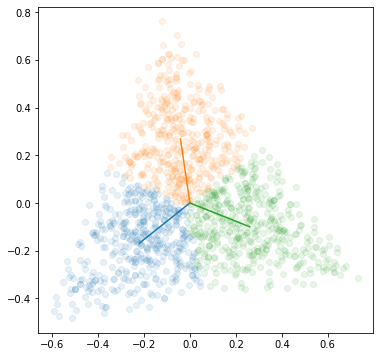

In [27]:
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
  # 'words': ['kinda0', 'kinda1', 'kinda2', 'the'],
  'uniform_score': True, # Uniform distribution over scores
  # 'filter': 24.0
}

toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
toy_params['base_word_vals'] = syn.baseWordValues(toy_params)

train_params = {'train_set_size': 1280}

train_params, toy_params, _ = syn_train.default_params(train_params, toy_params, {})

syn_data = syn.generate_data(train_params['train_set_size'], toy_params, len(toy_params['sentiments']), jnp_arrays=False)

state_sums = np.zeros((len(toy_params['sentiments']), len(toy_params['words'])))
n_states = np.zeros((len(toy_params['sentiments'])))
states = []

for sent, sent_idx in zip(toy_params['sentiments'], range(len(toy_params['sentiments']))):
  states.append([np.sum(input, axis=0) for input, lbl in zip(syn_data['inputs'], syn_data['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == sent_idx])
  state_sums[sent_idx] = np.sum(states[sent_idx], axis=0)
  n_states[sent_idx] = len(states[sent_idx])
# subtracts mean across all states
mean_state = np.sum(state_sums, axis=0) / (train_params['train_set_size']*toy_params['phrase_length'])

state_sums_norm = np.zeros((len(toy_params['sentiments']), len(toy_params['words'])))

for state_idx in range(state_sums.shape[0]):
  state_sums_norm[state_idx] = state_sums[state_idx]/(n_states[state_idx]*toy_params['phrase_length']) - mean_state
  for i in range(int(n_states[state_idx])):
    states[state_idx][i] = states[state_idx][i]/toy_params['phrase_length'] - mean_state

pca_full = PCA(n_components=np.min([len(toy_params['sentiments']), len(toy_params['words'])]))
states_pca = pca_full.fit_transform(state_sums_norm)
explained_var = pca_full.explained_variance_ratio_
print('Explained Variance:', explained_var,'')
print('Participation Ratio:', syn_an.participation_ratio_vector(pca_full.explained_variance_))

pc1 = 0
pc2 = 1

plt.figure(figsize=(6,6))
for state_idx in range(state_sums.shape[0]):
  plt.plot([0, states_pca[state_idx,pc1]], [0, states_pca[state_idx,pc2]])
  pca_state = pca_full.transform(states[state_idx])
  print(pca_state.shape)
  plt.scatter(pca_state[:, pc1], pca_state[:, pc2], alpha=0.1)

plot_coords = None
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

In [38]:
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'unordered_class': True, # Use an unordered class set
  'uniform_score': True, # Uniform distribution over scores
}

class_size = [2, 3, 4, 5, 6, 7, 8, 9, 10]
var_exp = []
class_dims = []

train_params = {'train_set_size': 1280}

for class_idx in range(len(class_size)):
  toy_params['n_unordered'] = class_size[class_idx]
  toy_params['words'] = syn.generateWordBank(toy_params)

  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
  toy_params['base_word_vals'] = syn.baseWordValues(toy_params)

  train_params, toy_params, _ = syn_train.default_params(train_params, toy_params, {})

  syn_data = syn.generate_data(train_params['train_set_size'], toy_params, len(toy_params['sentiments']), jnp_arrays=False)

  state_sums = np.zeros((len(toy_params['sentiments']), len(toy_params['words'])))
  n_states = np.zeros((len(toy_params['sentiments'])))
  states = []

  for sent, sent_idx in zip(toy_params['sentiments'], range(len(toy_params['sentiments']))):
    states.append([np.sum(input, axis=0) for input, lbl in zip(syn_data['inputs'], syn_data['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == sent_idx])
    state_sums[sent_idx] = np.sum(states[sent_idx], axis=0)
    n_states[sent_idx] = len(states[sent_idx])
  # subtracts mean across all states
  mean_state = np.sum(state_sums, axis=0) / (train_params['train_set_size']*toy_params['phrase_length'])

  state_sums_norm = np.zeros((len(toy_params['sentiments']), len(toy_params['words'])))

  for state_idx in range(state_sums.shape[0]):
    state_sums_norm[state_idx] = state_sums[state_idx]/(n_states[state_idx]*toy_params['phrase_length']) - mean_state
    for i in range(int(n_states[state_idx])):
      states[state_idx][i] = states[state_idx][i]/toy_params['phrase_length'] - mean_state

  pca_full = PCA(n_components=np.min([len(toy_params['sentiments']), len(toy_params['words'])]))
  states_pca = pca_full.fit_transform(state_sums_norm)
  explained_var = pca_full.explained_variance_ratio_
  explained_var_sum = [np.sum(explained_var[:i+1]) for i in range(class_size[class_idx])]
  var_exp.append(explained_var_sum)
  class_dims.append([i+1 for i in range(class_size[class_idx])])
  print('Explained Variance:', explained_var,'')
  print('Participation Ratio:', syn_an.participation_ratio_vector(pca_full.explained_variance_))

Sythentic data generated in: 0.65 sec. Autobalanced: False. Uniform score: True
Explained Variance: [1. 0.] 
Participation Ratio: 1.0
Sythentic data generated in: 0.93 sec. Autobalanced: False. Uniform score: True
Explained Variance: [5.44384157e-01 4.55615843e-01 8.63257459e-34] 
Participation Ratio: 1.984363585066902
Sythentic data generated in: 1.10 sec. Autobalanced: False. Uniform score: True
Explained Variance: [3.62532968e-01 3.25779046e-01 3.11687986e-01 1.86247087e-33] 
Participation Ratio: 2.9876472108533743
Sythentic data generated in: 1.24 sec. Autobalanced: False. Uniform score: True
Explained Variance: [2.71850891e-01 2.51247287e-01 2.47863436e-01 2.29038386e-01
 6.40721634e-34] 
Participation Ratio: 3.985286778331484
Sythentic data generated in: 1.34 sec. Autobalanced: False. Uniform score: True
Explained Variance: [2.21748606e-01 2.18503999e-01 1.92489404e-01 1.85652659e-01
 1.81605332e-01 1.98905653e-33] 
Participation Ratio: 4.964848403593328
Sythentic data generated 

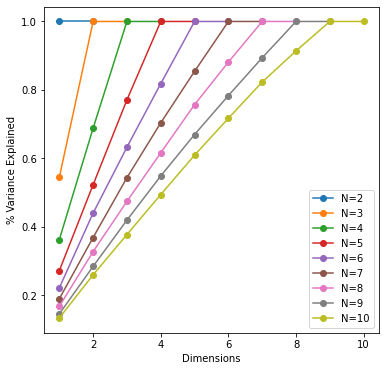

In [43]:
plt.figure(figsize=(6,6))
for class_idx in range(len(class_size)):
  plt.plot(class_dims[class_idx],var_exp[class_idx], marker='o', label='N='+str(class_size[class_idx]))

plt.xlabel('Dimensions')
plt.ylabel('% Variance Explained')
plt.legend()


# Bag of Words Tests

In [ ]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    targets = batch['labels'][:,toy_params['phrase_length']-1]
    data_loss = -jnp.mean(jnp.sum(targets * logits, axis=1))
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    target_labels = jnp.argmax(batch['labels'][:,toy_params['phrase_length']-1], axis=1)
    return jnp.mean(predictions == target_labels)

@jax.jit
def bow_step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params):
    return jnp.array([accuracy(params, syn_data_test)])

In [ ]:
toy_params = {
  'phrase_length': 48,
  'loss_type': 'XE',
  'context_words' : False,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
  'words': ['kinda0', 'kinda1', 'kinda2'],
  'uniform_score': True, # Uniform distribution over scores
  'filter': 24.0
}

# toy_params['words'] = generateWordBank(toy_params)
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
toy_params['base_word_vals'] = baseWordValues(toy_params)

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 2000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs']

train_params, toy_params, rnn_specs = default_params(train_params, toy_params, {})

input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
l2_pen = 1e-3

# Linear model
init_fun, apply_fun = stax.serial(
    SequenceSum(),
    stax.Dense(len(toy_params['sentiments'])),
    stax.LogSoftmax,
)

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

f_df = jax.value_and_grad(xent)

# Train
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []
global_step = 0
total_steps = 0
batch_size = train_params['batch_size']
num_batchs = train_params['num_batchs']

syn_data = generate_data(train_params['train_set_size'], toy_params, len(toy_params['sentiments']))
syn_data_test = generate_data(train_params['test_set_size'], toy_params, len(toy_params['sentiments']))


for epoch in range(train_params['epochs']):
  # Shuffles training data after first epoch
  if epoch > 0:
    print('Shuffling Data')
    syn_data = shuffle_data(syn_data)

  print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
  start_time = time.time()  
  avg_loss = 0 
  for step in range(total_steps, total_steps+num_batchs):
    batch = step - total_steps 
    batch_data = {
      'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
      'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
      'index': syn_data['index'], # Target mask: list of integers up to phrase_len
    }
    
    state, loss = bow_step(global_step, state, batch_data)
    losses.append(loss)
    avg_loss += loss
    global_step += 1

    if (global_step+1) % train_params['print_every'] == 0:
      acc = np.mean(test_acc(get_params(state)))
      batch_time = time.time() - start_time
      step_size = learning_rate(global_step)
      s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
      print(s.format(global_step+1, batch_time, step_size, acc, avg_loss/train_params['print_every']))
      start_time = time.time()
      avg_loss = 0

# Paper Plots

#### 3-Class Unordered Plots

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_uniformscore_noRO_l2is5e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = rnn_states(syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=5e-4, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'kinda2', 'the']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/3)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = 'lightgrey', marker='o', alpha=0.5)
  for state_idx in range(6,9): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.7,0.27,0.27]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.7,0.27,0.27]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=state_colors[word_idx])
  ax3.scatter(defs1, defs2, color=state_colors[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-5, 7)
y_lims = (-5, 7)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


In [ ]:
take_every = 5
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals_mag = np.zeros((int(n_fp/take_every), n_top))
max_evals = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

# input_word = jnp.zeros(rnn_specs['input_size'])
input_word = 1/4*jnp.ones(rnn_specs['input_size'])

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = fixed_points[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, input_word, fp))
  _, E, _ = renn.eigsorted(jac)
  Emags = np.absolute(E)
  rE = np.real(E)
  rE.sort()
  Emags.sort()
  max_evals_mag[i] = Emags[-n_top:]
  max_evals[i] = rE[-n_top:]

In [ ]:
tc_means = np.zeros((n_top,)) 
tc_medians = np.zeros((n_top,))
tc_75perc = np.zeros((n_top,)) 
tc_25perc = np.zeros((n_top,)) 
tc_err_bars = np.zeros((2, n_top)) 
for i in range(n_top):
  tcs = np.abs(1/np.log(max_evals_mag[:,n_top-1-i]))
  tc_means[i] = np.mean(tcs)
  tc_medians[i] = np.median(tcs)
  tc_75perc[i] = np.percentile(tcs, 90) 
  tc_25perc[i] = np.percentile(tcs, 10)
  tc_err_bars[0,i] = tc_medians[i]-tc_25perc[i]
  tc_err_bars[1,i] = tc_75perc[i] - tc_medians[i] 


plt.figure()
plt.errorbar(np.asarray(range(n_top))+1, tc_medians, yerr=tc_err_bars, xerr=None, uplims=True, lolims=True, marker='o', color='k')
plt.axhline(50, color='k', linestyle='dashed')
plt.xlabel('Top Magnitude Eigenvalue')
plt.ylabel('|Time Constant|')

#### 3-Class Ordered Plots

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3class_uniformscore_noRO_l2is1e-2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = rnn_states(syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/3*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=3e-3, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.1
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
steps = 1

words = ['bad', 'the', 'good']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/3)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = 'lightgrey', marker='o', alpha=0.5)
  for state_idx in range(6,9): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.7,0.27,0.27]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.7,0.27,0.27]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['g', 'y', 'r', 'b', 'orange', 'm', 'cyan', 'brown']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=def_colors[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-7, 7)
y_lims = (-3, 9)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


####5-Class Ordered Plots

In [35]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_noRO_l2is1e-3_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [36]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/3*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.025
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(fixed_points, unique_tol, do_print)
steps = 1

words = ['bad', 'the', 'good']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [120. 120. 120. 120. 120.]
Sythentic data generated in: 0.06 sec. Autobalanced: True. Uniform score: True
(14700, 128)
Copy this: PCA: [0.43076158 0.30506012 0.21788324 0.03049179 0.00421562] PR: 3.0576005477014863
Category 0 states: 120
Category 1 states: 120
Category 2 states: 120
Category 3 states: 120
Category 4 states: 120
Using word tensor: [0.33333334 0.33333334 0.33333334]
    Kept 11304/14700 unique fixed points with uniqueness tolerance 0.025000.


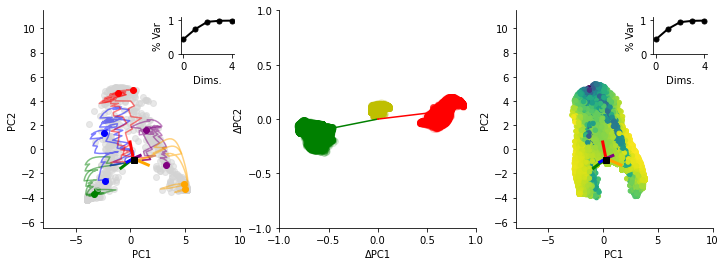

In [39]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'purple', 'orange', 'm', 'cyan', 'brown']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/5)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = 'lightgrey', marker='o', alpha=0.5)
  for state_idx in range(2): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['g', 'y', 'r', 'b', 'orange', 'm', 'cyan', 'brown']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=def_colors[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-8, 10)
y_lims = (-6.5, 11.5)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


In [40]:
take_every = 5
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals_mag = np.zeros((int(n_fp/take_every), n_top))
max_evals = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

# input_word = jnp.zeros(rnn_specs['input_size'])
input_word = 1/4*jnp.ones(rnn_specs['input_size'])

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = fixed_points[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, input_word, fp))
  _, E, _ = renn.eigsorted(jac)
  Emags = np.absolute(E)
  rE = np.real(E)
  rE.sort()
  Emags.sort()
  max_evals_mag[i] = Emags[-n_top:]
  max_evals[i] = rE[-n_top:]

Evaluating 14700 fixed points.


Text(0, 0.5, '|Time Constant|')

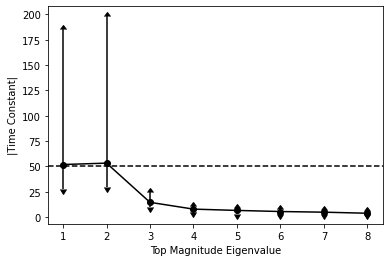

In [43]:
tc_means = np.zeros((n_top,)) 
tc_medians = np.zeros((n_top,))
tc_75perc = np.zeros((n_top,)) 
tc_25perc = np.zeros((n_top,)) 
tc_err_bars = np.zeros((2, n_top)) 
for i in range(n_top):
  tcs = np.abs(1/np.log(max_evals_mag[:,n_top-1-i]))
  tc_means[i] = np.mean(tcs)
  tc_medians[i] = np.median(tcs)
  tc_75perc[i] = np.percentile(tcs, 90) 
  tc_25perc[i] = np.percentile(tcs, 10)
  tc_err_bars[0,i] = tc_medians[i]-tc_25perc[i]
  tc_err_bars[1,i] = tc_75perc[i] - tc_medians[i] 


plt.figure()
plt.errorbar(np.asarray(range(n_top))+1, tc_medians, yerr=tc_err_bars, xerr=None, uplims=True, lolims=True, marker='o', color='k')
plt.axhline(50, color='k', linestyle='dashed')
plt.xlabel('Top Magnitude Eigenvalue')
plt.ylabel('|Time Constant|')

#### Non-Exclusive Plots

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2classrgb_2outer_noRO_l2is5e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 200
pc_dims = 5

syn_data_test = generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = rnn_states(syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
state_vecs = np.asarray([[0,1], [1,0], [0,0], [1,1]])
for i in range(len(toy_params['sentiments'])**2):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if (lbl[toy_params['phrase_length']-1] == state_vecs[i]).all()])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-4, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'bad0', 'bad1', 'the']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['b', 'r', 'grey', 'purple', 'orange', 'm', 'cyan', 'brown']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])**2):
  for state_idx in range(1): # Only plots 1 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
ro_colors = ['r', 'b']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.7,0.27,0.27]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.7,0.27,0.27]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['r', 'b', 'pink', 'lightskyblue', 'y']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=def_colors[word_idx], alpha=0.1)
  ax3.set_xlim(-2,2)
  ax3.set_xticks([-2, -1, 0, 1, 2])
  ax3.set_yticks([-2, -1, 0, 1, 2])
  ax3.set_ylim(-2,2)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-6, 10)
y_lims = (-6, 10)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)